In [89]:
import pandas as pd
import glob
import regex as re
import querygen as qg

In [90]:
files = glob.glob("results/*.csv")
dfs = [pd.read_csv(f, index_col=0) for f in files]
files

['results/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results/eval_results_BTO_oneshot_unsloth-Mistral-Small-3.1-24B-Instruct-2503-GGUF.csv',
 'results/eval_results_Yago_oneshot_unsloth-Mistral-Small-3.1-24B-Instruct-2503-GGUF.csv',
 'results/eval_results_Yago_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results/eval_results_UniProt_oneshot_NousResearch-Hermes-3-Llama-3.2-3B-GGUF.csv',
 'results/eval_results_BTO_zeroshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results/eval_results_DBpedia_oneshot_unsloth-Mistral-Small-3.1-24B-Instruct-2503-GGUF.csv',
 'results/eval_results_DBpedia_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results/eval_results_UniProt_oneshot_bartowski-Qwen2.5-Coder-32B-Instruct-GGUF.csv',
 'results/eval_results_Yago_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results/eval_results_UniProt_oneshot_NousResearch-Hermes-3-Llama-3.1-8B-GGUF.csv',
 'results/eval_results_Yago_oneshot_bartowski-Mistra

In [91]:
dfs

[      f1_score  precision    recall  f1_score_rel  precision_rel  recall_rel  \
 0     0.666667   0.666667  0.666667      0.000000          0.000       0.000   
 1     0.000000   0.000000  0.000000      0.000000          0.000       0.000   
 2     1.000000   1.000000  1.000000      1.000000          1.000       1.000   
 3     0.500000   0.500000  0.500000      0.000000          0.000       0.000   
 4     0.000000   0.000000  0.000000      0.000000          0.000       0.000   
 ...        ...        ...       ...           ...            ...         ...   
 2329  0.000000   0.000000  0.000000      0.000000          0.000       0.000   
 2330  0.500000   0.600000  0.428571      0.333333          0.500       0.250   
 2331  0.769231   0.833333  0.714286      0.875000          0.875       0.875   
 2332  0.000000   0.000000  0.000000      0.000000          0.000       0.000   
 2333  0.666667   0.800000  0.571429      0.666667          1.000       0.500   
 
         ged  normed_ged  

In [92]:

def graph_from_erl(erl: qg.EnrichedEntitiesRelations):
    G = qg.nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity,
            link.target,
            weight=link.link.instance_count,
            label=link.relation,
        )
    return G

In [120]:
model_map = {
    "NousResearch Hermes 3 Llama 3.2 3B": "Hermes 3 3B",
    "NousResearch Hermes 3 Llama 3.1 8B": "Hermes 3 8B",
    "bartowski Mistral Small Instruct": "Mistral Small 24B",
    "bartowski Qwen2.5 Coder 32B": "Qwen2.5 Coder 32B",
    "bartowski Qwen2.5 Instruct 32B": "Qwen2.5 Instruct 32B",
}
chosen_models = [
    "Hermes 3 3B",
    "Hermes 3 8B",
    "Qwen2.5 Coder 32B",
    "Qwen2.5 Instruct 32B",
]

In [145]:
dfs_model_clean = []
for f, df in zip(files, dfs):
    # data=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    # prompt_type=re.findall(r"results/eval_results_(\w+)_.*", f)[0]
    model = re.findall(r"results/eval_results_\w+_(.+)\.csv", f)[0]
    # df['prompt_type'] = prompt_type
    df["model"] = model.replace("_", " ").replace("-", " ")
    df["model"] = df["model"].apply(
        lambda x: next((v for k, v in model_map.items() if x.startswith(k)), x)
    )
    df = df[df["model"].isin(chosen_models)]
    dfs_model_clean.append(df)
df = pd.concat(dfs_model_clean)
df

/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_91490/290279044.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat(dfs_model_clean)


f1_score  precision    recall  f1_score_rel  precision_rel  recall_rel  \
0     0.666667   0.666667  0.666667      0.000000       0.000000       0.000   
1     0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2     1.000000   1.000000  1.000000      1.000000       1.000000       1.000   
3     0.500000   0.500000  0.500000      0.000000       0.000000       0.000   
4     0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
...        ...        ...       ...           ...            ...         ...   
2098  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2099  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2100  0.666667   0.800000  0.571429      0.166667       0.250000       0.125   
2101  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2102  0.727273   1.000000  0.571429      0.181818       0.333333       0.125   

       ged  normed_ged                                           response  \
0      3.0    0.400000       A animal, born in nature, but died in a town   
1      5.0    0.000000       A animal, born in nature, but died in a town   
2      0.0    1.000000       A animal, born in nature, but died in a town   
3      2.0    0.333333           A step in the career of a musical artist   
4      3.0    0.000000           A step in the career of a musical artist   
...    ...         ...                                                ...   
2098   5.0    0.000000  A sports team has a member and the same member...   
2099   6.0   -0.200000  A sports team has a member and the same member...   
2100  12.0    0.076923  A person is a member of a sports team, has dir...   
2101  93.0   -0.056818  A person is a member of a sports team, has dir...   
2102  86.0    0.022727  A person is a member of a sports team, has dir...   

                  model cfg_name zeroshot        stage  \
0           Hermes 3 3B  DBpedia    False          raw   
1           Hermes 3 3B  DBpedia    False  constrained   
2           Hermes 3 3B  DBpedia    False      aligned   
3           Hermes 3 3B  DBpedia    False          raw   
4           Hermes 3 3B  DBpedia    False  constrained   
...                 ...      ...      ...          ...   
2098  Qwen2.5 Coder 32B  DBpedia    False  constrained   
2099  Qwen2.5 Coder 32B  DBpedia    False      aligned   
2100  Qwen2.5 Coder 32B  DBpedia    False          raw   
2101  Qwen2.5 Coder 32B  DBpedia    False  constrained   
2102  Qwen2.5 Coder 32B  DBpedia    False      aligned   

                                                    erl generator  n_nodes  \
0     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
1     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
2     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
3     {"relations":[{"entity":"musical artist","rela...     human      3.0   
4     {"relations":[{"entity":"musical artist","rela...     human      3.0   
...                                                 ...       ...      ...   
2098  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2099  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2100  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2101  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2102  {"relations":[{"entity":"sports team","relatio...     llama      7.0   

       seed                                         erl_loaded  
0      60.0  relations=[EnrichedRelation(entity='animal', r...  
1      60.0  relations=[EnrichedRelation(entity='animal', r...  
2      60.0  relations=[EnrichedRelation(entity='animal', r...  
3      12.0  relations=[EnrichedRelation(entity='musical ar...  
4      12.0  relations=[EnrichedRelation(entity='musical ar...  
...     ...                                                ...  
2098  125.0  relations=[Enriche

In [146]:
df["model"].unique()

array(['Hermes 3 3B', 'Hermes 3 8B', 'Qwen2.5 Coder 32B'], dtype=object)

In [147]:
df["prompt_type"] = df["zeroshot"].apply(lambda x: "zero shot" if x else "one shot")
df.drop(columns=["zeroshot"], inplace=True)
df

f1_score  precision    recall  f1_score_rel  precision_rel  recall_rel  \
0     0.666667   0.666667  0.666667      0.000000       0.000000       0.000   
1     0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2     1.000000   1.000000  1.000000      1.000000       1.000000       1.000   
3     0.500000   0.500000  0.500000      0.000000       0.000000       0.000   
4     0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
...        ...        ...       ...           ...            ...         ...   
2098  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2099  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2100  0.666667   0.800000  0.571429      0.166667       0.250000       0.125   
2101  0.000000   0.000000  0.000000      0.000000       0.000000       0.000   
2102  0.727273   1.000000  0.571429      0.181818       0.333333       0.125   

       ged  normed_ged                                           response  \
0      3.0    0.400000       A animal, born in nature, but died in a town   
1      5.0    0.000000       A animal, born in nature, but died in a town   
2      0.0    1.000000       A animal, born in nature, but died in a town   
3      2.0    0.333333           A step in the career of a musical artist   
4      3.0    0.000000           A step in the career of a musical artist   
...    ...         ...                                                ...   
2098   5.0    0.000000  A sports team has a member and the same member...   
2099   6.0   -0.200000  A sports team has a member and the same member...   
2100  12.0    0.076923  A person is a member of a sports team, has dir...   
2101  93.0   -0.056818  A person is a member of a sports team, has dir...   
2102  86.0    0.022727  A person is a member of a sports team, has dir...   

                  model cfg_name        stage  \
0           Hermes 3 3B  DBpedia          raw   
1           Hermes 3 3B  DBpedia  constrained   
2           Hermes 3 3B  DBpedia      aligned   
3           Hermes 3 3B  DBpedia          raw   
4           Hermes 3 3B  DBpedia  constrained   
...                 ...      ...          ...   
2098  Qwen2.5 Coder 32B  DBpedia  constrained   
2099  Qwen2.5 Coder 32B  DBpedia      aligned   
2100  Qwen2.5 Coder 32B  DBpedia          raw   
2101  Qwen2.5 Coder 32B  DBpedia  constrained   
2102  Qwen2.5 Coder 32B  DBpedia      aligned   

                                                    erl generator  n_nodes  \
0     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
1     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
2     {"relations":[{"entity":"animal","relation":"b...     human      3.0   
3     {"relations":[{"entity":"musical artist","rela...     human      3.0   
4     {"relations":[{"entity":"musical artist","rela...     human      3.0   
...                                                 ...       ...      ...   
2098  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2099  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2100  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2101  {"relations":[{"entity":"sports team","relatio...     llama      7.0   
2102  {"relations":[{"entity":"sports team","relatio...     llama      7.0   

       seed                                         erl_loaded prompt_type  
0      60.0  relations=[EnrichedRelation(entity='animal', r...    one shot  
1      60.0  relations=[EnrichedRelation(entity='animal', r...    one shot  
2      60.0  relations=[EnrichedRelation(entity='animal', r...    one shot  
3      12.0  relations=[EnrichedRelation(entity='musical ar...    one shot  
4      12.0  relations=[EnrichedRelation(entity='musical ar...    one shot  
...     ...                                                ...         ...  
2098  125.0  relations=[EnrichedRelation(entity='sports

In [148]:
df_clean = df.dropna()
df_clean.describe()

,f1_score,precision,recall,f1_score_rel,precision_rel,recall_rel,ged,normed_ged,n_nodes,seed
count,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000,26376.000000
mean,0.268761,0.286549,0.262495,0.308692,0.320171,0.305656,8.215802,0.189504,4.031733,60.695974
std,0.372491,0.392186,0.370809,0.425317,0.437942,0.425708,23.230862,0.312616,1.863498,37.649415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.384615,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,28.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,3.000000,59.000000
75%,0.500000,0.600000,0.500000,0.750000,1.000000,0.750000,8.000000,0.333333,5.000000,93.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,409.000000,1.000000,10.000000,231.000000


In [149]:
df["erl_loaded"] = df["erl"].apply(qg.EnrichedEntitiesRelations.model_validate_json)
# df["response_loaded"] = df["response"].apply(lambda x: qg.EnrichedEntitiesRelations.model_validate_json(x) if isinstance(x, str) else None)
df["erl_graph"] = df["erl_loaded"].apply(graph_from_erl)
# df["response_graph"] = df["response"].apply(lambda x: graph_from_erl if x is not None else None)

In [150]:
# df["normed_ged"] = 1 - df["ged"] / df["erl_graph"].apply(
#     lambda x: (len(x.nodes) + len(x.nodes))
# )

In [151]:
df_clean["generator"].unique(), df_clean["model"].unique()

(array(['human', 'llama', 'templated'], dtype=object),
 array(['Hermes 3 3B', 'Hermes 3 8B', 'Qwen2.5 Coder 32B'], dtype=object))

In [152]:
means = df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].mean()
stds= df_clean.groupby(
    ["n_nodes", "prompt_type", "stage", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].std()
counts = df_clean.groupby(
    ["n_nodes", "stage", "prompt_type", "model", "generator", "cfg_name"]
)[["f1_score", "normed_ged"]].count()
means

f1_score  \
n_nodes prompt_type stage       model       generator cfg_name             
2.0     one shot    aligned     Hermes 3 3B llama     BTO       0.472358   
                                                      DBpedia   0.628616   
                                                      UniProt   0.529004   
                                                      Yago      0.636508   
                                            templated BTO       0.586957   
...                                                                  ...   
10.0    zero shot   aligned     Hermes 3 8B human     DBpedia   0.558333   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.279739   

                                                                normed_ged  
n_nodes prompt_type stage       model       generator cfg_name              
2.0     one shot    aligned     Hermes 3 3B llama     BTO         0.401760  
                                                      DBpedia     0.468264  
                                                      UniProt     0.520111  
                                                      Yago        0.506325  
                                            templated BTO         0.417909  
...                                                                    ...  
10.0    zero shot   aligned     Hermes 3 8B human     DBpedia     0.298571  
                    constrained Hermes 3 3B human     DBpedia    -0.144528  
                                Hermes 3 8B human     DBpedia    -0.187619  
                    raw         Hermes 3 3B human     DBpedia    -0.100251  
                                Hermes 3 8B human     DBpedia    -0.020802  

[510 rows x 2 columns]

In [153]:
stds

f1_score  \
n_nodes prompt_type stage       model       generator cfg_name             
2.0     one shot    aligned     Hermes 3 3B llama     BTO       0.309292   
                                                      DBpedia   0.378285   
                                                      UniProt   0.381263   
                                                      Yago      0.344736   
                                            templated BTO       0.300629   
...                                                                  ...   
10.0    zero shot   aligned     Hermes 3 8B human     DBpedia   0.376109   
                    constrained Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.000000   
                    raw         Hermes 3 3B human     DBpedia   0.000000   
                                Hermes 3 8B human     DBpedia   0.375024   

                                                                normed_ged  
n_nodes prompt_type stage       model       generator cfg_name              
2.0     one shot    aligned     Hermes 3 3B llama     BTO         0.287281  
                                                      DBpedia     0.340872  
                                                      UniProt     0.304955  
                                                      Yago        0.320383  
                                            templated BTO         0.305081  
...                                                                    ...  
10.0    zero shot   aligned     Hermes 3 8B human     DBpedia     0.145427  
                    constrained Hermes 3 3B human     DBpedia     0.124113  
                                Hermes 3 8B human     DBpedia     0.097993  
                    raw         Hermes 3 3B human     DBpedia     0.045321  
                                Hermes 3 8B human     DBpedia     0.141757  

[510 rows x 2 columns]

In [154]:
counts

f1_score  \
n_nodes stage   prompt_type model             generator cfg_name             
2.0     aligned one shot    Hermes 3 3B       llama     BTO             41   
                                                        DBpedia        106   
                                                        UniProt         77   
                                                        Yago            63   
                                              templated BTO             23   
...                                                                    ...   
10.0    raw     one shot    Hermes 3 3B       human     DBpedia          3   
                            Hermes 3 8B       human     DBpedia          3   
                            Qwen2.5 Coder 32B human     DBpedia          3   
                zero shot   Hermes 3 3B       human     DBpedia          3   
                            Hermes 3 8B       human     DBpedia          3   

                                                                  normed_ged  
n_nodes stage   prompt_type model             generator cfg_name              
2.0     aligned one shot    Hermes 3 3B       llama     BTO               41  
                                                        DBpedia          106  
                                                        UniProt           77  
                                                        Yago              63  
                                              templated BTO               23  
...                                                                      ...  
10.0    raw     one shot    Hermes 3 3B       human     DBpedia            3  
                            Hermes 3 8B       human     DBpedia            3  
                            Qwen2.5 Coder 32B human     DBpedia            3  
                zero shot   Hermes 3 3B       human     DBpedia            3  
                            Hermes 3 8B       human     DBpedia            3  

[510 rows x 2 columns]

In [155]:
column_map = {
    "f1_score": "$F_{1,node}$",
    "f1_score_rel": "$F_{1,rel.}$ ",
    "normed_ged": "$GED_{s}$",
    "stage": "Stage",
    "prompt_type": "Prompt Type",
    "model": "Version \\& Size",
    "n_nodes": "$k$",
    "generator": "Query Origin",
}

## Compare Query Origins on DBpedia with 8B model

In [156]:
query_gen_compare = df_clean[
    df_clean["model"].str.contains("3B")
    & df_clean["cfg_name"].str.contains("DBpedia")
    & df_clean["prompt_type"].str.contains("one shot")
    & ~df_clean["stage"].str.contains("constrained")
    & (df_clean["n_nodes"] < 6)
    & (df_clean["n_nodes"] > 2)
]
grouped_query_gen_compare = query_gen_compare.groupby(
    ["n_nodes", "generator", "stage"]
)[["f1_score", "normed_ged"]]
grouped_query_gen_compare_mean=grouped_query_gen_compare.mean()
grouped_query_gen_compare_std=grouped_query_gen_compare.std()
grouped_query_gen_compare_percentiles = grouped_query_gen_compare.quantile(
    [0.25, 0.5, 0.75]
)
grouped_query_gen_compare_mean = grouped_query_gen_compare_mean.rename(
    columns=column_map
).rename_axis(
    [column_map["n_nodes"], column_map["generator"], column_map["stage"]], axis=0
)
with open("tables/compare_gen_query.tex", "w") as f:
    f.write(
        grouped_query_gen_compare_mean.to_latex(
            float_format="%.2f",
            caption="Comparison of query generation methods for LLama 3.2 3B on DBpedia with one shot prompts.",
            label="tab:compare_gen_query",
        )
    )
grouped_query_gen_compare_mean

$F_{1,node}$  $GED_{s}$
$k$ Query Origin Stage                           
3.0 human        aligned      0.633333   0.400000
                 raw          0.522222   0.244444
    llama        aligned      0.710957   0.459299
                 raw          0.680996   0.364789
    templated    aligned      0.811856   0.568738
                 raw          0.791343   0.537818
5.0 human        aligned      0.687831   0.215488
                 raw          0.896296   0.269360
    llama        aligned      0.663717   0.337104
                 raw          0.674941   0.254612
    templated    aligned      0.827500   0.478308
                 raw          0.742327   0.446131

In [157]:
grouped_query_gen_compare_percentiles

f1_score  normed_ged
n_nodes generator stage                             
3.0     human     aligned 0.25  0.450000    0.100000
                          0.50  0.500000    0.200000
                          0.75  0.750000    0.600000
                  raw     0.25  0.450000    0.166667
                          0.50  0.500000    0.333333
                          0.75  0.583333    0.366667
        llama     aligned 0.25  0.475000    0.200000
                          0.50  0.800000    0.414286
                          0.75  1.000000    0.666667
                  raw     0.25  0.475000    0.191667
                          0.50  0.666667    0.366667
                          0.75  1.000000    0.600000
        templated aligned 0.25  0.666667    0.333333
                          0.50  1.000000    0.500000
                          0.75  1.000000    1.000000
                  raw     0.25  0.666667    0.250000
                          0.50  0.857143    0.500000
                          0.75  1.000000    0.825000
5.0     human     aligned 0.25  0.587302   -0.010101
                          0.50  0.888889    0.090909
                          0.75  0.888889    0.378788
                  raw     0.25  0.844444    0.222222
                          0.50  0.888889    0.333333
                          0.75  0.944444    0.348485
        llama     aligned 0.25  0.500000    0.142857
                          0.50  0.750000    0.333333
                          0.75  0.800000    0.500000
                  raw     0.25  0.545455    0.111111
                          0.50  0.666667    0.222222
                          0.75  0.857143    0.400000
        templated aligned 0.25  0.727273    0.174242
                          0.50  0.888889    0.454545
                          0.75  1.000000    0.752525
                  raw     0.25  0.600000    0.214286
                          0.50  0.800000    0.384615
                          0.75  1.000000    0.636364

## Compare models across Datasets

In [158]:
datasets = [
    "DBpedia",
    "UniProt",
    "BTO",
    "Yago",
    # "DNB",
]
quantiles = [0.25, 0.5, 0.75]
grouped_dfs: dict[str, pd.DataFrame] = {}
grouped_dfs_raw: dict[str, pd.DataFrame] = {}
for dataset in datasets:
    model_compare = df_clean[df_clean["cfg_name"].str.strip() == dataset]
    model_compare = model_compare[~model_compare["stage"].str.contains("constrained")]
    grouped_model_compare = model_compare.groupby(
        [
            "n_nodes",
            "stage",
            "prompt_type",
            "model",
            # "generator",
        ]
    )[
        [
            "f1_score",
            "normed_ged",
            "f1_score_rel",
        ]
    ].quantile(quantiles)
    grouped_dfs_raw[dataset] = (
        grouped_model_compare.rename_axis(
            [
                "n_nodes",
                "stage",
                "prompt_type",
                "model",
                "percentile",
            ]
        )
        .reset_index()
        .copy()
    )
    grouped_model_compare = grouped_model_compare.rename(
        columns=column_map
    ).rename_axis(
        [
            column_map["n_nodes"],
            column_map["stage"],
            column_map["prompt_type"],
            column_map["model"],
            "Percentile",
            # column_map["generator"],
        ],
        axis=0,
    )
    grouped_dfs[dataset] = grouped_model_compare
    with open(f"tables/compare_model_{dataset}.tex", "w") as f:
        f.write(
            grouped_model_compare.to_latex(
                float_format="%.2f",
                caption=f"Comparison of models for {dataset}",
                label=f"tab:compare_model_{dataset}",
                # sparsify=False
            )
        )
dataset_keys = list(grouped_dfs.keys())
merged_grouped: pd.DataFrame = grouped_dfs[dataset_keys[0]].copy()
merged_grouped.rename(
    columns={
        "$F_{1,node}$": f"$F_{{1,node}}$_{dataset_keys[0]}",
        "$F_{1,rel.}$": f"$F_{{1,rel.}}$_{dataset_keys[0]}",
        "$GED_{s}$": f"$GED_{{s}}$_{dataset_keys[0]}",
    },
    inplace=True,
)
for dataset, grouped_df in list(grouped_dfs.items())[1:]:
    print(f"Merging {dataset} into the grouped DataFrame")
    merged_grouped = pd.merge(
        merged_grouped,
        grouped_dfs[dataset].rename(
            columns={
                column_map["f1_score"]: f"{column_map['f1_score']}_{dataset}",
                column_map["f1_score_rel"]: f"{column_map['f1_score_rel']}_{dataset}",
                column_map["normed_ged"]: f"{column_map['normed_ged']}_{dataset}",
            }
        ),
        on=[
            "$k$",
            "Stage",
            "Prompt Type",
            "Version \\& Size",
            "Percentile",
        ],
        # suffixes=(None, f"_{dataset}"),
    )
rename_map = (
    {
        f"{column_map['f1_score']}_{dataset}": f"{dataset} {column_map['f1_score']}"
        for dataset in datasets
    }
    | {
        f"{column_map['f1_score_rel']}_{dataset}": f"{dataset} {column_map['f1_score_rel']}"
        for dataset in datasets
    }
    | {
        f"{column_map['normed_ged']}_{dataset}": f"{dataset} {column_map['normed_ged']}"
        for dataset in datasets
    }
)
merged_grouped.rename(
    columns=rename_map,
    inplace=True,
)
with open("tables/compare_model_merged.tex", "w") as f:
    f.write(
        merged_grouped.to_latex(
            float_format="%.2f",
            caption="Comparison of models for DBpedia and UniProt",
            label="tab:compare_model_merged",
        )
    )

Merging UniProt into the grouped DataFrame
Merging BTO into the grouped DataFrame
Merging Yago into the grouped DataFrame


In [159]:
merged_grouped

DBpedia $F_{1,node}$  \
$k$ Stage   Prompt Type Version \& Size Percentile                         
2.0 aligned one shot    Hermes 3 3B     0.25                    0.500000   
                                        0.50                    0.800000   
                                        0.75                    1.000000   
                        Hermes 3 8B     0.25                    0.000000   
                                        0.50                    0.500000   
...                                                                  ...   
7.0 raw     zero shot   Hermes 3 3B     0.50                    0.000000   
                                        0.75                    0.000000   
                        Hermes 3 8B     0.25                    0.000000   
                                        0.50                    0.000000   
                                        0.75                    0.363636   

                                                    DBpedia $GED_{s}$  \
$k$ Stage   Prompt Type Version \& Size Percentile                      
2.0 aligned one shot    Hermes 3 3B     0.25                 0.200000   
                                        0.50                 0.450000   
                                        0.75                 0.750000   
                        Hermes 3 8B     0.25                 0.200000   
                                        0.50                 0.400000   
...                                                               ...   
7.0 raw     zero shot   Hermes 3 3B     0.50                 0.000000   
                                        0.75                 0.000000   
                        Hermes 3 8B     0.25                -0.112179   
                                        0.50                 0.000000   
                                        0.75                 0.072802   

                                                    $F_{1,rel.}$   \
$k$ Stage   Prompt Type Version \& Size Percentile                  
2.0 aligned one shot    Hermes 3 3B     0.25                  0.0   
                                        0.50                  1.0   
                                        0.75                  1.0   
                        Hermes 3 8B     0.25                  0.0   
                                        0.50                  1.0   
...                                                           ...   
7.0 raw     zero shot   Hermes 3 3B     0.50                  0.0   
                                        0.75                  0.0   
                        Hermes 3 8B     0.25                  0.0   
                                        0.50                  0.0   
                                        0.75                  0.0   

                                                    UniProt $F_{1,node}$  \
$k$ Stage   Prompt Type Version \& Size Percentile                         
2.0 aligned one shot    Hermes 3 3B     0.25                    0.400000   
                                        0.50                    0.500000   
                                        0.75                    1.000000   
                        Hermes 3 8B     0.25                    0.400000   
                                        0.50                    0.500000   
...                                                                  ...   
7.0 raw     zero shot   Hermes 3 3B     0.50                    0.000000   
                                        0.75                    0.000000   
                        Hermes 3 8B     0.25                    0.000000   
                                        0.50                    0.000000   
                                        0.75                    0.223214   

                                                    UniProt $GED_{s}$  \
$k$ Stage   Prompt Type Version \& Size Percentile                      
2.0 aligned one shot    Hermes 3 3B     0.25                 0.333333   
       

In [160]:
grouped_dfs_raw

{'DBpedia':      n_nodes    stage prompt_type        model  percentile  f1_score  \
 0        2.0  aligned    one shot  Hermes 3 3B        0.25  0.500000   
 1        2.0  aligned    one shot  Hermes 3 3B        0.50  0.800000   
 2        2.0  aligned    one shot  Hermes 3 3B        0.75  1.000000   
 3        2.0  aligned    one shot  Hermes 3 8B        0.25  0.000000   
 4        2.0  aligned    one shot  Hermes 3 8B        0.50  0.500000   
 ..       ...      ...         ...          ...         ...       ...   
 145     10.0      raw   zero shot  Hermes 3 3B        0.50  0.000000   
 146     10.0      raw   zero shot  Hermes 3 3B        0.75  0.000000   
 147     10.0      raw   zero shot  Hermes 3 8B        0.25  0.066667   
 148     10.0      raw   zero shot  Hermes 3 8B        0.50  0.133333   
 149     10.0      raw   zero shot  Hermes 3 8B        0.75  0.419608   
 
      normed_ged  f1_score_rel  
 0      0.200000           0.0  
 1      0.450000           1.0  
 2      0.75

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble="""\\usepackage{amsmath}""")
plt.style.use("fivethirtyeight")
# set background color to white of the figure and axes
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)


# https://github.com/nschloe/tikzplotlib/issues/567
# from matplotlib.lines import Line2D
# from matplotlib.legend import Legend

# Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
# Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
# Legend._ncol = property(lambda self: self._ncols)

import seaborn as sns

palette = sns.color_palette('pastel').as_hex()
def adjust_lightness(color, amount=1.1):
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], np.maximum(0, np.minimum(1, amount * c[1])), c[2])

plt.rcParams.update({'errorbar.capsize': 2})

In [162]:
grouped_dfs["UniProt"].index.names

FrozenList(['$k$', 'Stage', 'Prompt Type', 'Version \& Size', 'Percentile'])

In [163]:
from matplotlib.lines import Line2D
# Filter out filled markers and marker settings that do nothing.
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]
unfilled_markers

[',',
 '1',
 '2',
 '3',
 '4',
 '+',
 'x',
 '|',
 '_',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11]

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


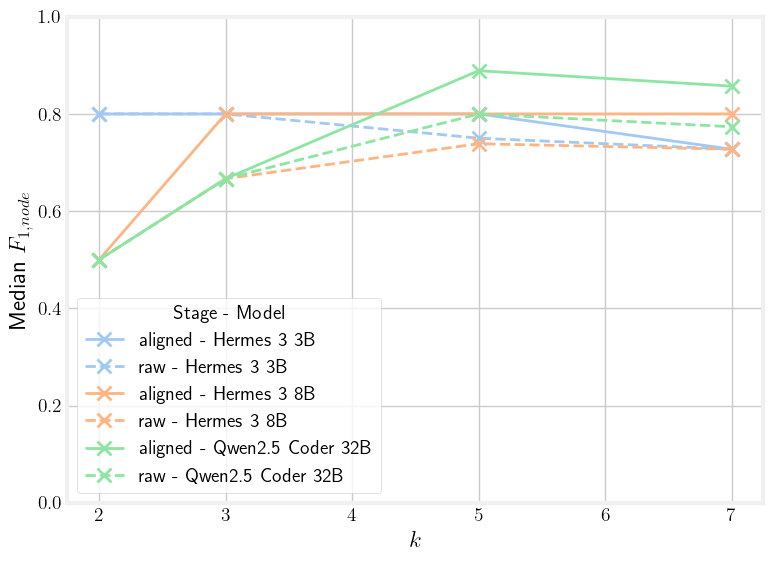

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


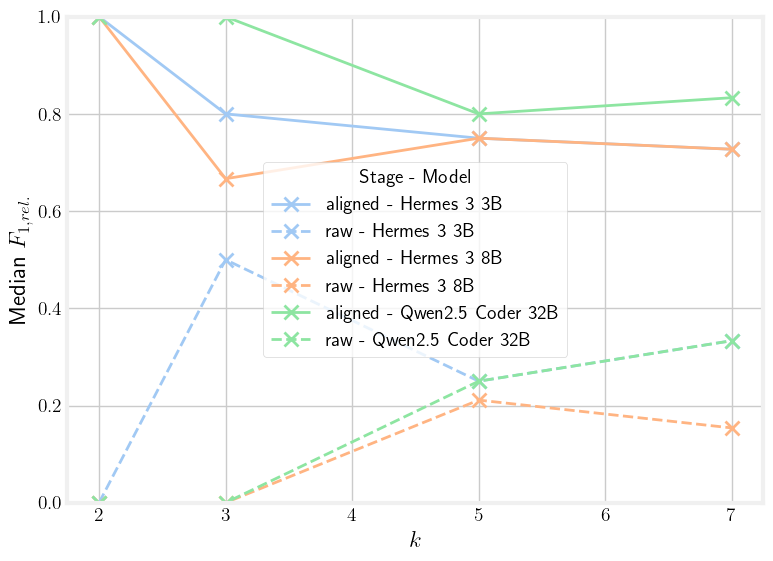

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


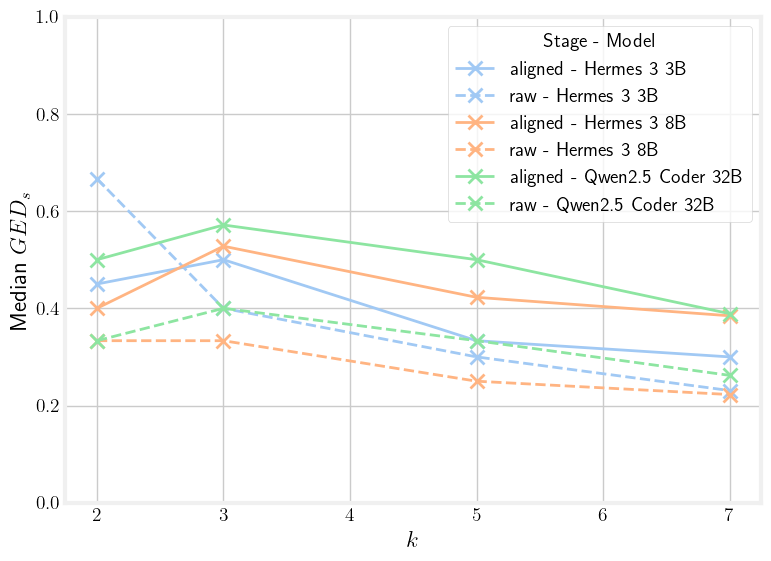

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


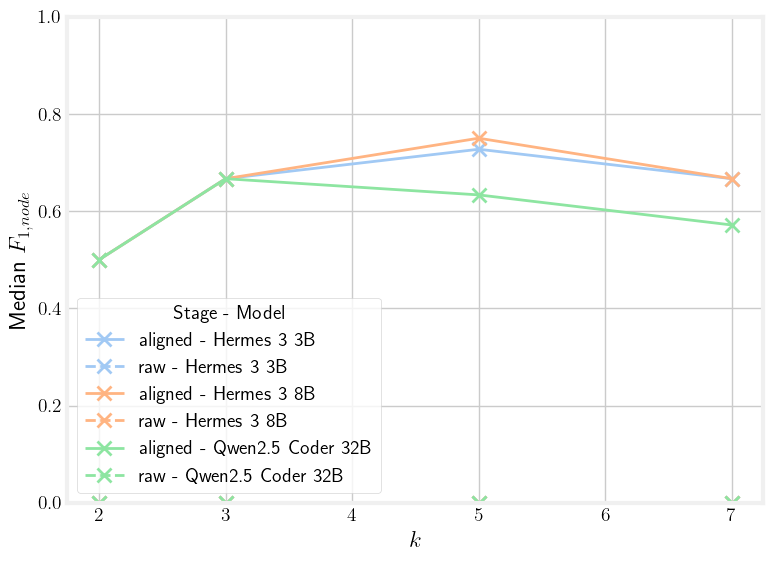

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


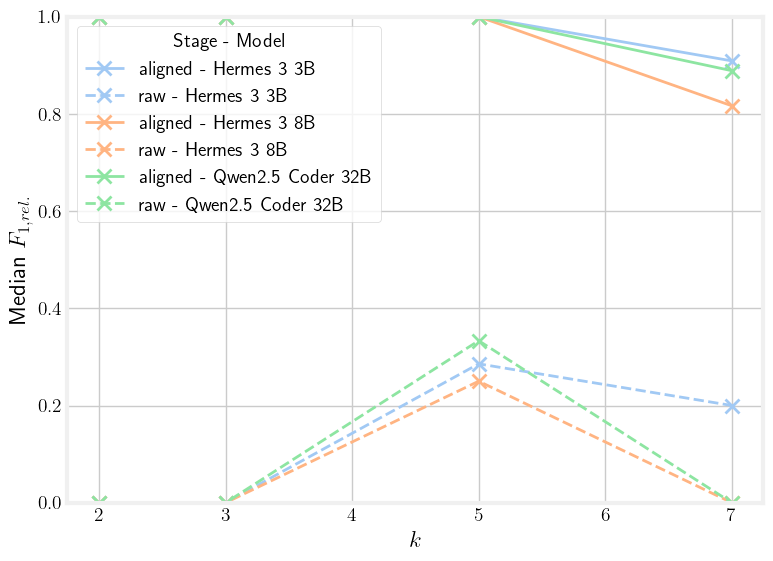

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


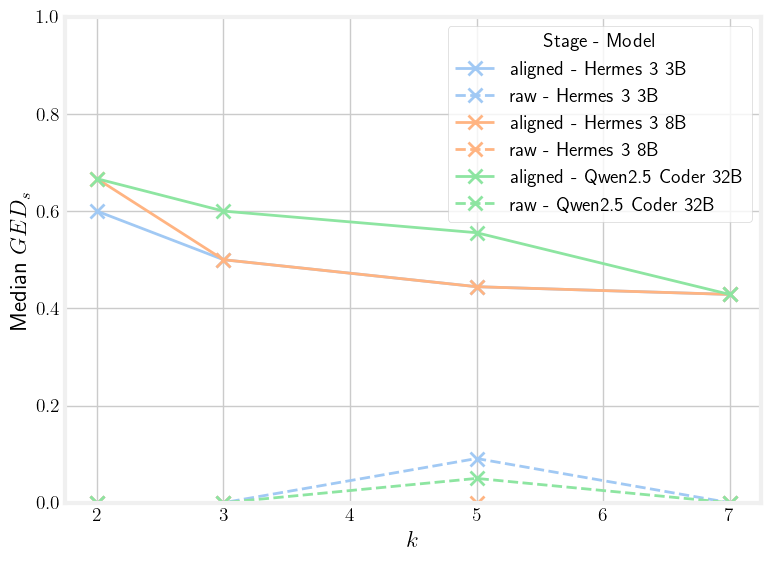

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


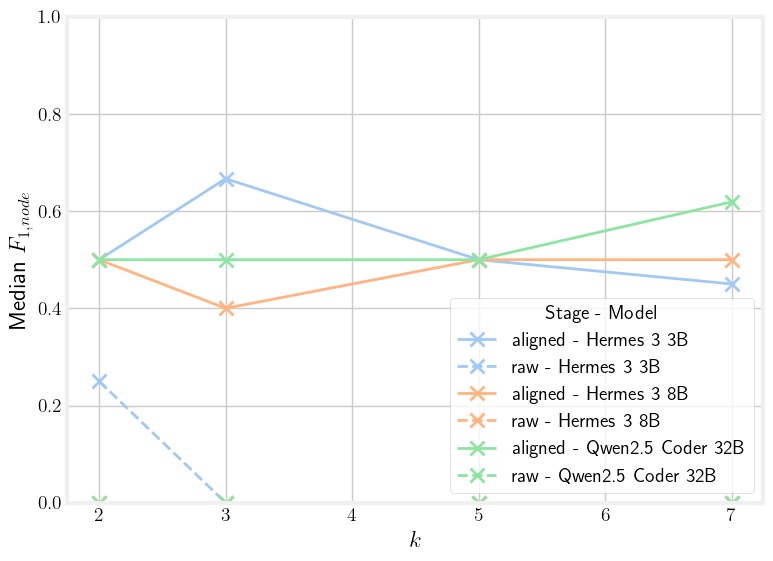

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


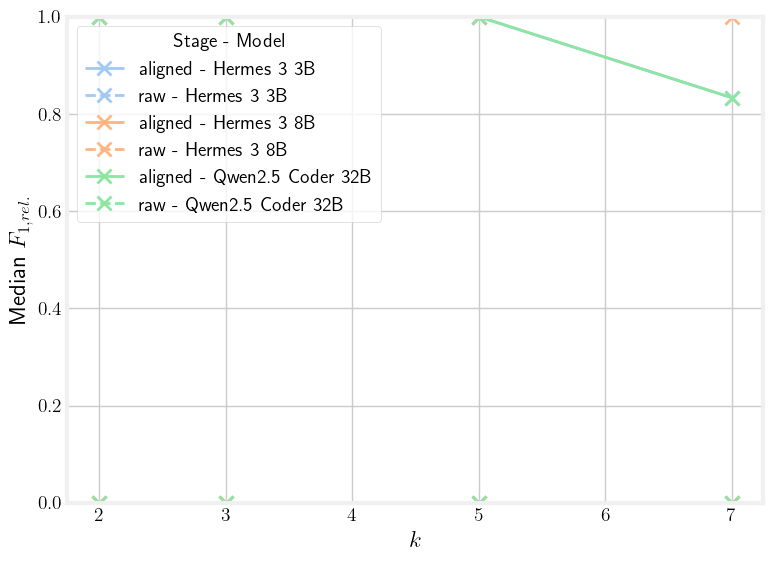

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


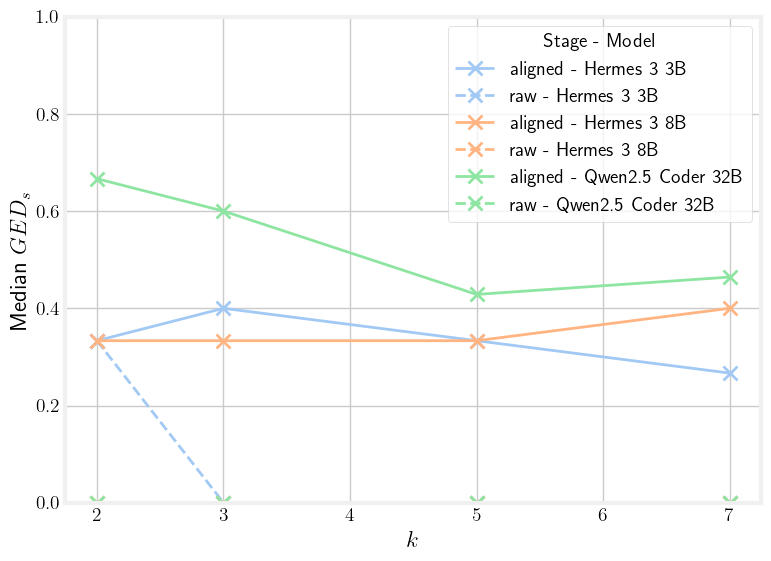

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


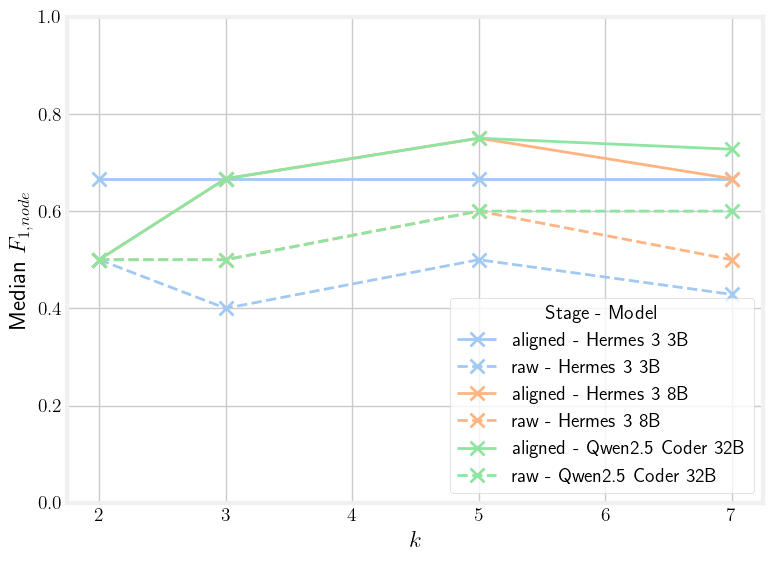

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


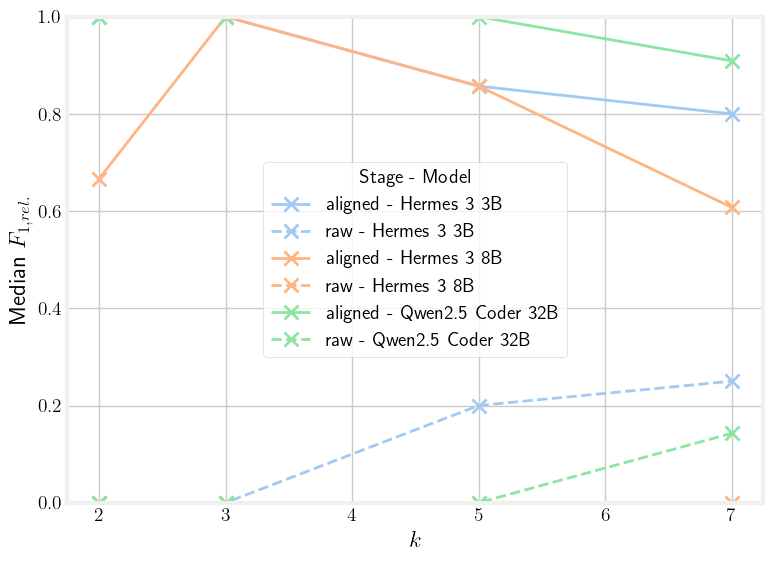

x solid #a1c9f4
x dashed #a1c9f4
x solid #ffb482
x dashed #ffb482
x solid #8de5a1
x dashed #8de5a1


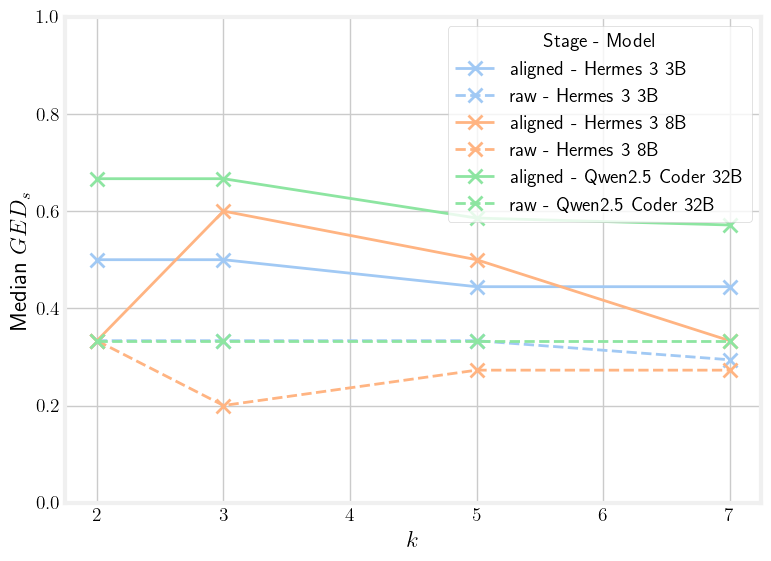

In [164]:
for dataset in grouped_dfs_raw.keys():
    df = grouped_dfs_raw[dataset].reset_index()
    df = df[(df["prompt_type"] == "one shot") & (df["n_nodes"] < 8)]
    metrics = [
        "f1_score",
        "f1_score_rel",
        "normed_ged",
    ]
    for metric in metrics:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        # fig.suptitle(f"{column_map[metric]} for {dataset}")
        patterns_stage = {
            "aligned": "solid",
            "raw": "dashed",
        }
        markers_stage = {
            "aligned": "x",
            "raw": "x",
        }
        for i, model in enumerate(df["model"].unique()):
            for stage in df["stage"].unique():
                data = df[(df["stage"] == stage) & (df["model"] == model)]
                lower, median, upper = tuple(
                    [
                        data[data["percentile"] == q][metric].to_numpy()
                        for q in quantiles
                    ]
                )
                k = data[data["percentile"] == quantiles[1]]["n_nodes"].to_numpy()
                if not data.empty:
                    # ax.errorbar(
                    #     k,
                    #     median,
                    #     yerr=np.abs(np.stack([lower, upper]) - median),
                    #     label=f"{stage} - {model}",
                    #     marker=markers_stage[stage],
                    #     fillstyle="none",
                    #     markeredgecolor=palette[i],
                    #     # markeredgewidth=10,
                    #     # barsabove=
                    #     capsize=5,
                    #     linestyle=patterns_stage[stage],
                    #     color=palette[i],
                    #     ecolor=adjust_lightness(palette[i]),
                    # )
                    ax.plot(
                        k,
                        median,
                        label=f"{stage} - {model}",
                        marker=markers_stage[stage],
                        fillstyle="none",
                        markeredgecolor=palette[i],
                        markersize=10,
                        markeredgewidth=2,
                        linewidth=2,
                        linestyle=patterns_stage[stage],
                        color=palette[i],
                    )
                    print(markers_stage[stage], patterns_stage[stage], palette[i])

        # ax.set_title(f"Comparison of {dataset} across stages and prompt types")
        ax.set_xlabel("$k$")
        ax.set_ylabel(f"Median {column_map[metric]}")
        ax.legend(title="Stage - Model")
        ax.set_ylim(0, 1)
        tikzplotlib.save(
            f"figures/compare_{dataset}_{metric}.tex",
            extra_tikzpicture_parameters=[
                "scale=0.5",
                """every axis/.style={legend pos=south west, legend style={
                font=\\small}
                }""",
            ],
            axis_height="1.5\\textwidth",
            axis_width="2\\textwidth",
        )
        plt.show()

In [165]:
np.stack([lower, upper]).shape

(2, 4)

In [166]:
upper-lower

array([0.66666667, 0.4       , 0.36406926, 0.35664336])

In [167]:
(upper - lower) / 2

array([0.33333333, 0.2       , 0.18203463, 0.17832168])